In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [6]:
filenames = ['snapshots/b8f3506c-3f65-11eb-9798-16f63a1aa8c9.jpg',
            'snapshots/cad5dade-3f65-11eb-9798-16f63a1aa8c9.jpg',
            'snapshots/d9790c50-3f65-11eb-9798-16f63a1aa8c9.jpg',
            'snapshots/e74fce5e-3f65-11eb-9798-16f63a1aa8c9.jpg']

In [4]:
def preprocessing(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3,3),0)
    gray = cv2.equalizeHist(gray)
    return gray

def watershed(img_gray):
    mean = np.average(img_gray)
    _, thresh1 = cv2.threshold(img_gray,mean,255,cv2.THRESH_BINARY_INV)
    _, thresh2 = cv2.threshold(img_gray,200,255,cv2.THRESH_BINARY)
    thresh = np.bitwise_or(thresh1, thresh2)

    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations=2)

    sure_bg = cv2.dilate(opening,kernel,iterations=2)

    dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,5)
    _, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
    sure_fg = np.uint8(sure_fg)

    unknown = cv2.subtract(sure_bg, sure_fg)

    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    markers = cv2.watershed(img,markers)
    return markers

def segment_road(img):
    gray = preprocessing(img)
    markers = watershed(gray)

    gray[np.where(markers>1)] = 255
    gray[:int(0.5*gray.shape[0]),:] = 255
    _, img_bi = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    closing = cv2.morphologyEx(img_bi,cv2.MORPH_CLOSE, np.ones((3,3),np.uint8),iterations=2)
    return closing

In [7]:
imgs = []
titles = []
for i, filename in enumerate(filenames):
    img = plt.imread(filename)
    img_bi = segment_road(img)
    imgs.append(img)
    imgs.append(img_bi)
    titles.append(f"img_{i}")
    titles.append(f"result_{i}")

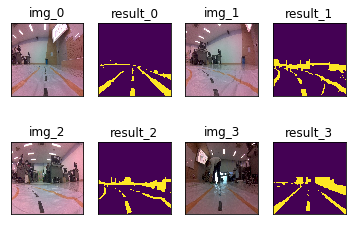

In [8]:
for i in range(len(imgs)):
    plt.subplot(2,4,i+1),plt.imshow(imgs[i]),plt.title(titles[i]),plt.xticks([]),plt.yticks([])
plt.show()